In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2e
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [2]:
# region constants
MONTHS = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

CLIMATE_DATA_DIRECTORY = "NOAA Climate Data/"


In [3]:
house_pricing = pd.read_csv("house_pricing.csv", index_col=False, sep="\t")
house_inflation = pd.read_csv("house_inflation.csv")

In [4]:
# normalized based on 2021 inflation
normalized_house_pricing = house_pricing.copy().rename(
    columns={
        "ABS-diff price Q2 2021": "Normalized Growth 2021",
        "Geography": "County",
    }
)

# drop NaN, cast % string to float, and normalize
normalized_house_pricing["Normalized Growth 2021"] = normalized_house_pricing[
    "Normalized Growth 2021"
].dropna().str.rstrip("%").astype("float") / (
    100.0 * house_inflation["Inflation Rate"][2021 - 1968]
)

# remove price ranges, growth Q42021, latlong, and full county number
normalized_house_pricing = normalized_house_pricing.drop(
    columns=[
        "Price Range-Q3 2022",
        "growth Q42021",
        "Latitude (generated)",
        "Full County Number",
        "Price Range-Q3 2022.1",
        "Longitude (generated)",
    ]
)


In [5]:
normalized_house_pricing = house_pricing.copy()

# rename ABS-diff price Q2 2021 to ABS-diff price Q2 2021
normalized_house_pricing = normalized_house_pricing.rename(columns={'ABS-diff price Q2 2021': 'Normalized Growth 2021', 'Geography': 'County'})

# cast percent string to float
normalized_house_pricing['Normalized Growth 2021'] = normalized_house_pricing['Normalized Growth 2021'].str.rstrip('%').astype('float') / 100.0

# remove NaN values
normalized_house_pricing = normalized_house_pricing.dropna()

# normalize house pricing based on 2021 inflation
normalized_house_pricing['Normalized Growth 2021'] = normalized_house_pricing['Normalized Growth 2021'] / house_inflation['Inflation Rate'][2021-1968]

# remove price ranges, growth q42021, latlong, and full county number
normalized_house_pricing = normalized_house_pricing.drop(columns=['Price Range-Q3 2022', 'growth Q42021', 'Latitude (generated)', 'Full County Number', 'Price Range-Q3 2022.1', 'Longitude (generated)'])

normalized_house_pricing.head()

,County,Normalized Growth 2021,Price Q3 2022,Q1 2022,Q4 2021
0,"Rusk County, Wisconsin",0.027356,"$140,764","$137,376","$139,179"
1,"Price County, Wisconsin",0.027356,"$147,838","$147,075","$150,348"
2,"Menominee County, Wisconsin",0.027356,"$103,510","$130,010","$124,942"
3,"Marinette County, Wisconsin",0.027356,"$147,130","$154,195","$151,944"
4,"Langlade County, Wisconsin",0.027356,"$145,951","$139,463","$139,793"


In [6]:
# region read NOAA data
cdd_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "cdd.tsv"),
    index_col=False,
    sep="\t",
)
hdd_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "hdd.tsv"),
    index_col=False,
    sep="\t",
)
precipitation_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "pcpn.tsv"),
    index_col=False,
    sep="\t",
)
avg_temp_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "tavg.tsv"),
    index_col=False,
    sep="\t",
)
min_temp_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "tmin.tsv"),
    index_col=False,
    sep="\t",
)
max_temp_data = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "tmax.tsv"),
    index_col=False,
    sep="\t",
)


In [7]:
for df in (
    cdd_data,
    hdd_data,
    precipitation_data,
    avg_temp_data,
    min_temp_data,
    max_temp_data,
):
    df["FIPS"] = df["Code"].apply(lambda x: int(str(x)[:-6]))
    df["Year"] = df["Code"].apply(lambda x: int(str(x)[-4:]))


fips = pd.read_csv(
    os.path.join(CLIMATE_DATA_DIRECTORY, "fips.csv"), index_col=False
)


In [8]:
# the NOAA uses different state codes at the beginning of the fips code
with open("noaa_state_codes.txt", "r") as f:
    noaa_state_codes = {
        line.split(",")[0].strip(): line.split(",")[1].strip()
        for line in f.readlines()
    }

# remove first 2 digits of each fips and replace with NOAA code for that state
fips["noaa_state_code"] = fips["state_name"].map(noaa_state_codes)
fips["fips"] = fips["fips"].astype("str").apply(lambda x: x[-3:])
fips["fips"] = (fips["noaa_state_code"] + fips["fips"]).dropna().astype("int")

fips_simple = fips[["fips", "long_name"]].rename(
    columns={"long_name": "County"}
)

# with open("log.txt", "w") as f:
#     f.write(fips_simple.to_string())

# convert state name at end of county name to state abbreviation in
# normalized_house_pricing
state_abbreviations = pd.read_csv("state_abbreviations.csv", index_col=False)


In [9]:
# convert normalized_house_pricing['State'] to state abbreviation
normalized_house_pricing["County"] = (
    normalized_house_pricing["County"].str.split(",").str[0]
    + " "
    + (
        normalized_house_pricing["County"]
        .str.split(",")
        .str[1]
        .str.strip()
        .map(state_abbreviations.set_index("state")["code"])
    )
)

# add fips column to normalized_house_pricing
normalized_house_pricing = normalized_house_pricing.merge(
    fips_simple, on="County"
)

# dropna for Washington DC
normalized_house_pricing["fips"] = (
    normalized_house_pricing["fips"].dropna().astype("int")
)

# print(normalized_house_pricing)


In [10]:
full_data = normalized_house_pricing.copy()

cdd_data_q3_2021 = cdd_data[cdd_data["Year"] == 2021]
hdd_data_q3_2021 = hdd_data[hdd_data["Year"] == 2021]
precipitation_data_q3_2021 = precipitation_data[
    precipitation_data["Year"] == 2021
]
avg_temp_data_q3_2021 = avg_temp_data[avg_temp_data["Year"] == 2021]
min_temp_data_q3_2021 = min_temp_data[min_temp_data["Year"] == 2021]
max_temp_data_q3_2021 = max_temp_data[max_temp_data["Year"] == 2021]


for (df, colname) in [
    (cdd_data_q3_2021, "cooling degree days"),
    (hdd_data_q3_2021, "heating degree days"),
    (precipitation_data_q3_2021, "precipitation"),
    (avg_temp_data_q3_2021, "average temperature"),
    (min_temp_data_q3_2021, "minimum temperature"),
    (max_temp_data_q3_2021, "maximum temperature"),
]:
    # print(df)
    full_data = full_data.merge(
        df.rename(
            {month: f"{month} {colname}" for month in MONTHS},
            axis=1,
        ),
        left_on=["fips"],
        right_on=["FIPS"],
    ).drop(
        columns=["FIPS", "Code", "Year"],
        axis=1,
    )

# print(full_data)


In [11]:
# remove the commas in between the prices in the Price Range-Q3 2022, Q1 2022,
# and Q4 2021 columns
for col in ("Price Q3 2022", "Q1 2022", "Q4 2021"):
    full_data[col] = (
        full_data[col]
        .str.replace(",", "", regex=False)
        .str.replace("$", "", regex=False)
        .astype(float)
    )
full_data = full_data.rename(
    columns={
        "Price Q3 2022": "Q3 2022 ($)",
        "Q1 2022": "Q1 2022 ($)",
        "Q4 2021": "Q4 2021 ($)",
    }
)

with open("log.txt", "w") as f:
    # sort by county name
    f.write(full_data.sort_values(by="County").to_string())

In [12]:
# --- Separate features and target ---
# full_data contains "Normalized Growth 2021", so we extract features (X) and target (y) separately.
X = full_data.drop(
    columns=[
        "County",
        "Normalized Growth 2021",
        "Q3 2022 ($)",
        "Q1 2022 ($)",
        "Q4 2021 ($)",
        "fips"
    ]
)
y = full_data["Normalized Growth 2021"]

# --- Scale only the features ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_features_df = pd.DataFrame(scaled_features, columns=X.columns)

# --- Create sequences for LSTM (time series forecasting) ---
def create_sequence_data(features_df, target_series, sequence_length):
    sequences = []
    labels = []
    # Ensure that you have enough rows to create a sequence plus a corresponding target
    for i in range(len(features_df) - sequence_length):
        # Create sequence from features
        sequences.append(features_df.iloc[i:i + sequence_length].values)
        # Get the label corresponding to the next time step from the target series
        labels.append(target_series.iloc[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 12  # Using 12 months of data to predict the next month's growth

# Create the sequence data using the scaled features and the original target series
X_seq, y_seq = create_sequence_data(scaled_features_df, y, sequence_length)

# Split into train and test sets
train_size = int(len(X_seq) * 0.75)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Reshaping is likely unnecessary if X_seq is already 3D, but ensuring correct shape:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [13]:
# Step 2: Build the LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
73/73 [==============================] - 3s 16ms/step - loss: 0.0054 - val_loss: 9.0980e-04
Epoch 2/50
73/73 [==============================] - 1s 12ms/step - loss: 9.6652e-05 - val_loss: 5.5684e-04
Epoch 3/50
73/73 [==============================] - 1s 11ms/step - loss: 7.7161e-05 - val_loss: 5.2454e-04
Epoch 4/50
73/73 [==============================] - 1s 10ms/step - loss: 5.2452e-05 - val_loss: 4.4404e-04
Epoch 5/50
73/73 [==============================] - 1s 10ms/step - loss: 4.7169e-05 - val_loss: 3.4482e-04
Epoch 6/50
73/73 [==============================] - 1s 11ms/step - loss: 4.0695e-05 - val_loss: 3.4987e-04
Epoch 7/50
73/73 [==============================] - 1s 11ms/step - loss: 3.6674e-05 - val_loss: 3.9036e-04
Epoch 8/50
73/73 [==============================] - 1s 11ms/step - loss: 3.5170e-05 - val_loss: 4.4444e-04
Epoch 9/50
73/73 [==============================] - 1s 11ms/step - loss: 3.2236e-05 - val_loss: 3.0635e-04
Epoch 10/50
73/73 [======================

In [14]:
# Step 4: Forecast 30 years ahead (360 months)
def forecast(model, input_sequence, forecast_steps):
    forecast = []
    current_input = input_sequence
    for _ in range(forecast_steps):
        next_step = model.predict(current_input[np.newaxis, :, :])[0, 0]
        forecast.append(next_step)
        current_input = np.roll(current_input, -1, axis=0)  # Slide the window forward
        current_input[-1, 0] = next_step  # Update the last element with the predicted value
    return forecast

# Take the last sequence from the test set as the starting point for forecasting
input_sequence = X_test[-1]

1/1 [==============================] - 0s 15ms/step


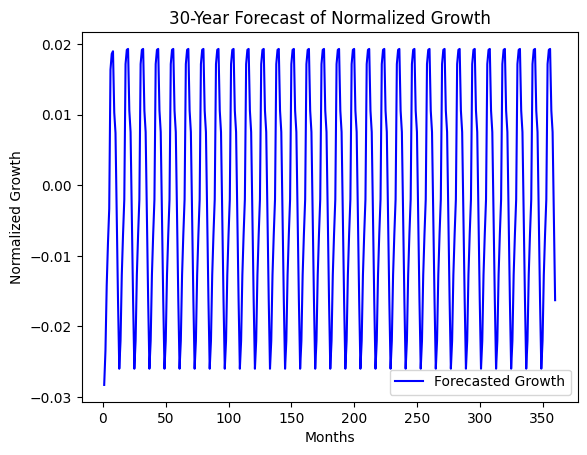

In [15]:
# Forecast for 30 years (360 months)
forecast_steps = 360  # 30 years * 12 months per year
forecast_values = forecast(model, input_sequence, forecast_steps)

# Plot the forecasted values
plt.plot(np.arange(1, forecast_steps + 1), forecast_values, color='blue', label='Forecasted Growth')
plt.title("30-Year Forecast of Normalized Growth")
plt.xlabel("Months")
plt.ylabel("Normalized Growth")
plt.legend()
plt.show()


In [16]:
# Calculate forecasted Mean Squared Error and R2 score
forecast_mse = mse(y_test[:forecast_steps], forecast_values[:forecast_steps])
forecast_r2 = r2e(y_test[:forecast_steps], forecast_values[:forecast_steps])

print("Forecast Mean Squared Error: %.6f" % forecast_mse)
print("Forecast Variance Score (R2): %.2f" % forecast_r2)


Forecast Mean Squared Error: 0.001404
Forecast Variance Score (R2): -11.78


In [20]:
# Scatter plot of predicted vs actual
plt.scatter(y_test, y_pred, color="black", label="Data points")

# Plot the ideal line (y = x)
plt.plot(
    [y_test.min(), y_test.max()], 
    [y_test.min(), y_test.max()], 
    "k--", lw=4, label="Ideal Fit"
)

# Calculate the line of best fit
coeffs = np.polyfit(y_test, y_pred, 1)
poly = np.poly1d(coeffs)
# Use a linspace to generate x-values over the range for a smooth line
x_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(
    x_line,
    poly(x_line),
    color="red",
    linewidth=3,
    label="Line of Best Fit",
)

plt.legend()
plt.title("Predicted vs Actual Normalized Growth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


NameError: name 'y_pred' is not defined

In [ ]:
# # do a train test split to predict house pricing normalized growth from climate data
# X = full_data.drop(columns=['County', 'Normalized Growth 2021'])
# y = full_data['Normalized Growth 2021']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # multivariate linear regression from climate data to house pricing normalized growth
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# # make predictions
# y_pred = regressor.predict(X_test)
# mean_squared_error = mean_squared_error(y_test, y_pred)

# # print mean squared error
# print('Mean squared error: %.2f' % mean_squared_error)
